# Python Flight Mechanics Engine 

This installs `pyfme` to be run in this online notebook

In [ ]:
!pip install git+https://github.com/AeroPython/PyFME.git

## Aircraft 

In order to perform a simulation, the first thing we need is an aircraft:

In [1]:
from pyfme.aircrafts import Cessna172

In [2]:
aircraft = Cessna172()

Aircraft will provide the simulator the forces, moments and inertial properties in order to perform the integration of the dynamic system equations:

In [3]:
print(f"Aircraft mass: {aircraft.mass} kg")
print(f"Aircraft inertia tensor: \n {aircraft.inertia} kg/m²")

Aircraft mass: 1043.2616 kg
Aircraft inertia tensor: 
 [[ 1285.3154166      0.             0.        ]
 [    0.          1824.9309607      0.        ]
 [    0.             0.          2666.89390765]] kg/m²


In [4]:
print(f"forces: {aircraft.total_forces} N")
print(f"moments: {aircraft.total_moments} N·m")

forces: [ 0.  0.  0.] N
moments: [ 0.  0.  0.] N·m


For the aircraft, in order to calculate its forces and moments it is necessary to set the controls values within the limits: 

In [5]:
print(aircraft.controls)

{'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0}


In [6]:
print(aircraft.control_limits)

{'delta_elevator': (-0.4537856055185257, 0.48869219055841229), 'delta_aileron': (-0.26179938779914941, 0.3490658503988659), 'delta_rudder': (-0.27925268031909273, 0.27925268031909273), 'delta_t': (0, 1)}


but also to provide and environment (ie. atmosphere, winds, gravity) and the aircraft state, which will also determine the aerodynamic contribution.

## Environment 

In [7]:
from pyfme.environment.atmosphere import ISA1976
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant

In [8]:
atmosphere = ISA1976()
gravity = VerticalConstant()
wind = NoWind()

The atmosphere, wind and gravity model make up the environment:

In [9]:
from pyfme.environment import Environment

In [10]:
environment = Environment(atmosphere, gravity, wind)

The environment has an update method which given the state (ie. position, altitude...) updates the environment variables (ie. density, wind magnitude, gravity force...)

In [11]:
help(environment.update)

Help on method update in module pyfme.environment.environment:

update(state) method of pyfme.environment.environment.Environment instance



## State 

Even if the state can be set manually by giving the position, attitude, velocity, angular velocities... Most of the times, the user will want to trim the aircraft in a stationary condition. The aircraft controls to flight in that condition will be also provided by the trimmer.

In [12]:
from pyfme.utils.trimmer import steady_state_trim

In [13]:
help(steady_state_trim)

Help on function steady_state_trim in module pyfme.utils.trimmer:

steady_state_trim(aircraft, environment, pos, psi, TAS, controls, gamma=0, turn_rate=0, exclude=None, verbose=0)
    Finds a combination of values of the state and control variables
    that correspond to a steady-state flight condition.
    
    Steady-state aircraft flight is defined as a condition in which all
    of the motion variables are constant or zero. That is, the linear and
    angular velocity components are constant (or zero), thus all
     acceleration components are zero.
    
    Parameters
    ----------
    aircraft : Aircraft
        Aircraft to be trimmed.
    environment : Environment
        Environment where the aircraft is trimmed including atmosphere,
        gravity and wind.
    pos : Position
        Initial position of the aircraft.
    psi : float, opt
        Initial yaw angle (rad).
    TAS : float
        True Air Speed (m/s).
    controls : dict
        Initial value guess for each con

In [14]:
from pyfme.models.state.position import EarthPosition

In [15]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}

In [16]:
trimmed_state, trimmed_controls = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)    

In [17]:
trimmed_state

Aircraft State 
x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
theta: 0.076 rad, phi: 0.000 rad, psi: 0.500 rad 
u: 44.87 m/s, v: -0.00 m/s, w: 3.40 m/s 
P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
u_dot: 0.00 m/s², v_dot: -0.00 m/s², w_dot: 0.00 m/s² 
P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: 0.00 rad/s² 

In [18]:
trimmed_controls

{'delta_aileron': -5.4944323898667417e-18,
 'delta_elevator': -0.048951124635247853,
 'delta_rudder': 2.3690975432909528e-17,
 'delta_t': 0.57799667845248526}

Now, all the necessary elements in order to calculate forces and moments are available 

In [19]:
# Environment conditions for the current state:
environment.update(trimmed_state)

# Forces and moments calculation:
forces, moments = aircraft.calculate_forces_and_moments(trimmed_state, environment, controls0)

In [20]:
forces, moments

(array([  1.48929757e-11,  -5.36867365e-18,   0.00000000e+00]),
 array([ -5.23207465e-13,  -1.45503653e-11,   1.08678966e-15]))

The aircraft is trimmed indeed: the total forces and moments (aerodynamics + gravity + thrust) are zero

## Simulation 

In order to simulate the dynamics of the aircraft under certain inputs in an environment, the user can set up a simulation using a dynamic system:

In [21]:
from pyfme.models import EulerFlatEarth

In [22]:
system = EulerFlatEarth(t0=0, full_state=trimmed_state)

### Constant Controls 

Let's set the controls for the aircraft during the simulation. As a first step we will set them constant and equal to the trimmed values.

In [23]:
from pyfme.utils.input_generator import Constant

In [24]:
controls = controls = {
    'delta_elevator': Constant(trimmed_controls['delta_elevator']),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [25]:
from pyfme.simulator import Simulation

In [26]:
sim = Simulation(aircraft, system, environment, controls)

Once the simulation is set, the propagation can be performed:

In [27]:
results = sim.propagate(10)

time: 100%|█████████▉| 9.999999999999831/10 [00:06<00:00,  1.44it/s]  


The results are returned in a DataFrame:

In [28]:
results

,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.01,1.489298e-11,2.865280e-16,0.000000e+00,0.133756,-5.000214e-13,-1.410812e-11,4.410351e-15,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.913472e-15,4.440892e-16,21.574149,39.491215,3.396464,0.394912,0.215741,-1000.0
0.02,1.489298e-11,1.835425e-16,0.000000e+00,0.133756,-4.778178e-13,-1.367932e-11,7.568961e-15,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.913679e-15,4.440892e-16,21.574149,39.491215,3.396464,0.789824,0.431483,-1000.0
0.03,1.489298e-11,-2.955912e-16,0.000000e+00,0.133756,-4.565544e-13,-1.326355e-11,1.056918e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.914028e-15,4.440892e-16,21.574149,39.491215,3.396464,1.184736,0.647224,-1000.0
0.04,1.489298e-11,-1.132942e-15,0.000000e+00,0.133756,-4.361907e-13,-1.286042e-11,1.341727e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.914521e-15,4.440892e-16,21.574149,39.491215,3.396464,1.579649,0.862966,-1000.0
0.05,1.489298e-11,-2.311347e-15,0.000000e+00,0.133756,-4.166881e-13,-1.246954e-11,1.611926e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.915162e-15,4.440892e-16,21.574149,39.491215,3.396464,1.974561,1.078707,-1000.0
0.06,1.489298e-11,-3.814381e-15,0.000000e+00,0.133756,-3.980095e-13,-1.209054e-11,1.868091e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.915953e-15,4.440892e-16,21.574149,39.491215,3.396464,2.369473,1.294449,-1000.0
0.07,1.466560e-11,-5.626319e-15,1.818989e-12,0.133756,-3.801197e-13,-1.172306e-11,2.110772e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.916897e-15,4.440892e-16,21.574149,39.491215,3.396464,2.764385,1.510190,-1000.0
0.08,1.443823e-11,-7.732114e-15,3.637979e-12,0.133756,-3.629847e-13,-1.098882e-11,2.171967e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.917995e-15,0.000000e+00,21.574149,39.491215,3.396464,3.159297,1.725932,-1000.0
0.09,1.512035e-11,-1.012088e-14,9.094947e-12,0.133756,-3.465899e-13,-1.027842e-11,2.254966e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.919249e-15,-4.440892e-16,21.574149,39.491215,3.396464,3.554209,1.941673,-1000.0


In [29]:
%matplotlib inline

In [30]:
kwargs = {'marker': '.',
          'subplots': True,
          'sharex': True,
          'figsize': (12, 6)}

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


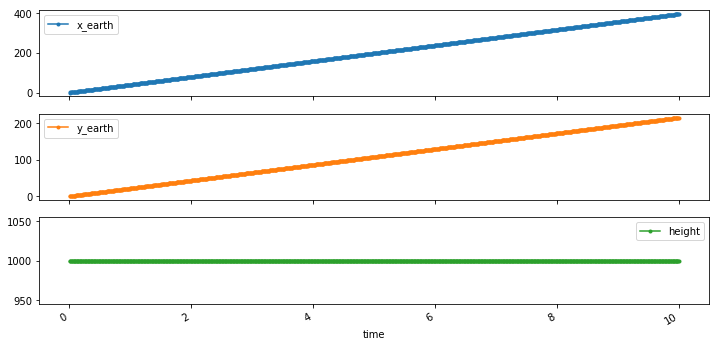

In [31]:
results.plot(y=['x_earth', 'y_earth', 'height'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


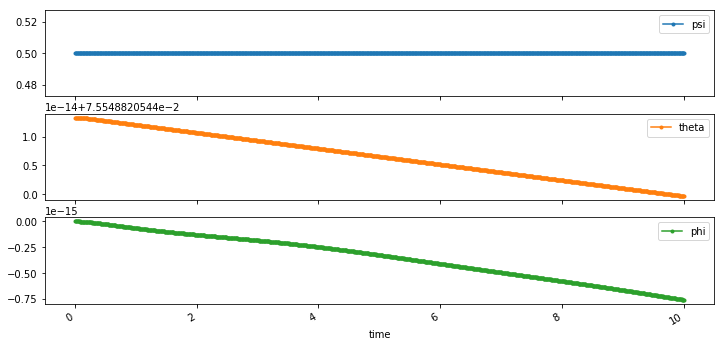

In [32]:
results.plot(y=['psi', 'theta', 'phi'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


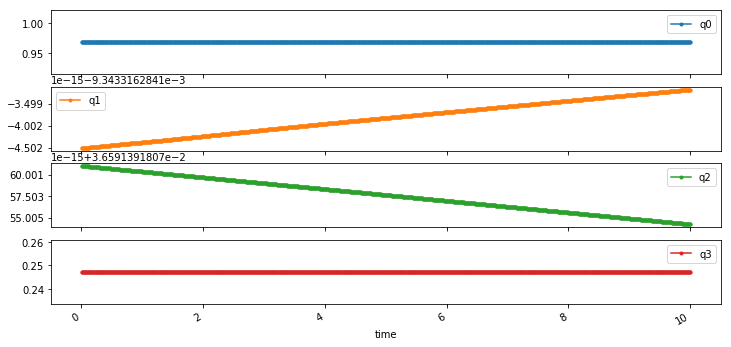

In [33]:
results.plot(y=['q0', 'q1', 'q2', 'q3'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


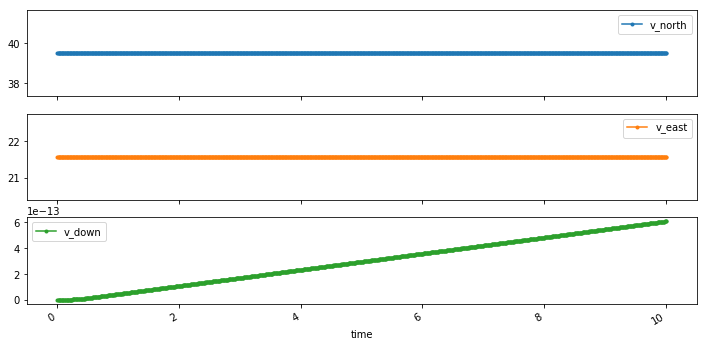

In [34]:
results.plot(y=['v_north', 'v_east', 'v_down'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


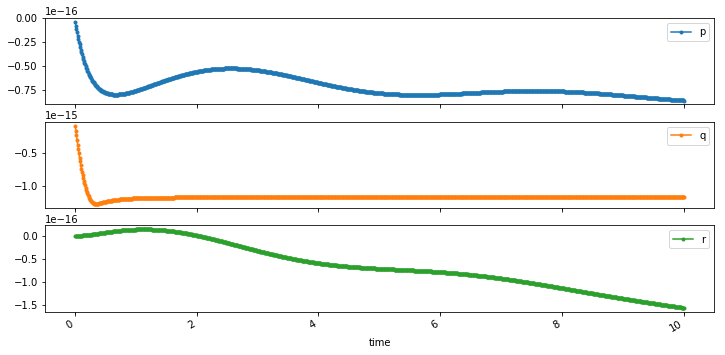

In [35]:
results.plot(y=['p', 'q', 'r'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


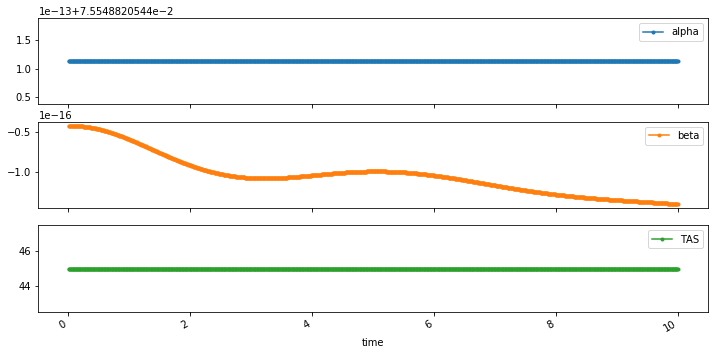

In [36]:
results.plot(y=['alpha', 'beta', 'TAS'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


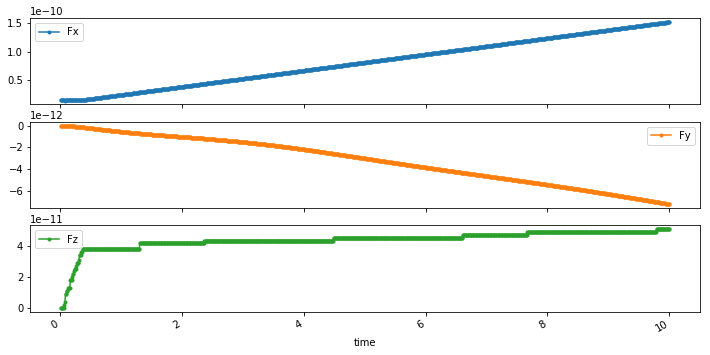

In [37]:
results.plot(y=['Fx', 'Fy', 'Fz'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


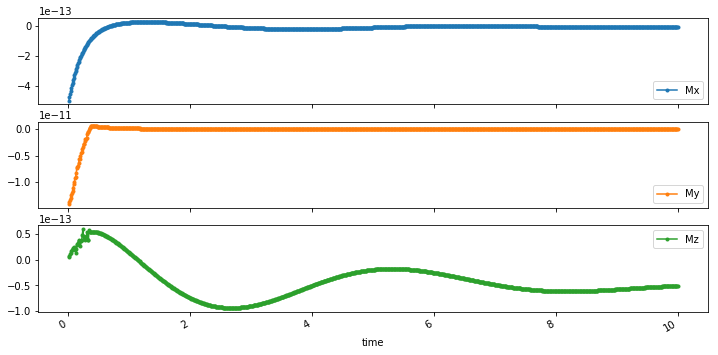

In [38]:
results.plot(y=['Mx', 'My', 'Mz'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


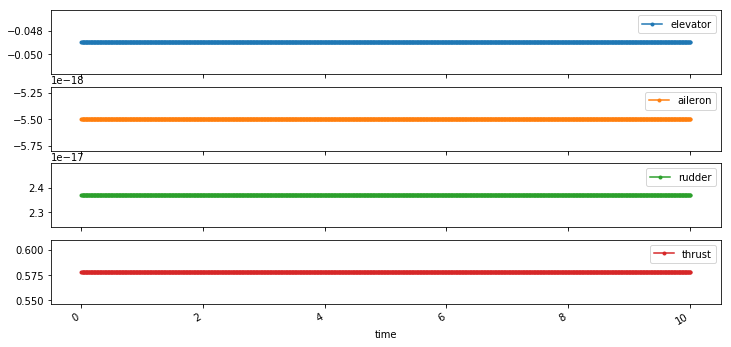

In [39]:
results.plot(y=['elevator', 'aileron', 'rudder', 'thrust'], **kwargs);

### Doublet 

Let's set the controls for the aircraft during the simulation. As a first step we will set them constant and equal to the trimmed values.

In [40]:
from pyfme.utils.input_generator import Doublet

In [41]:
de0 = trimmed_controls['delta_elevator']

In [42]:
controls = controls = {
    'delta_elevator': Doublet(t_init=2, T=1, A=0.1, offset=de0),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [43]:
sim = Simulation(aircraft, system, environment, controls)

Once the simulation is set, the propagation can be performed:

In [44]:
results = sim.propagate(90)

time: 90.00000000000914it [00:59,  1.50it/s]                          


/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


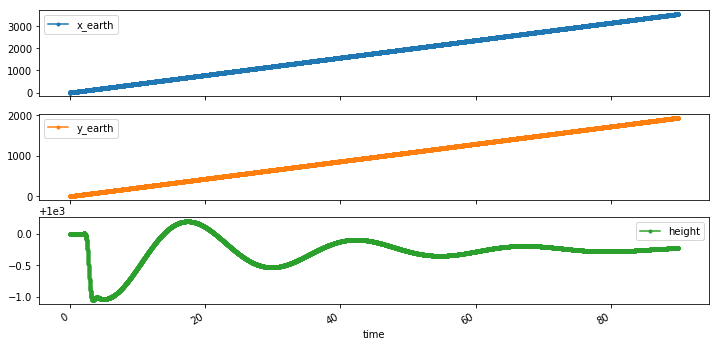

In [45]:
results.plot(y=['x_earth', 'y_earth', 'height'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


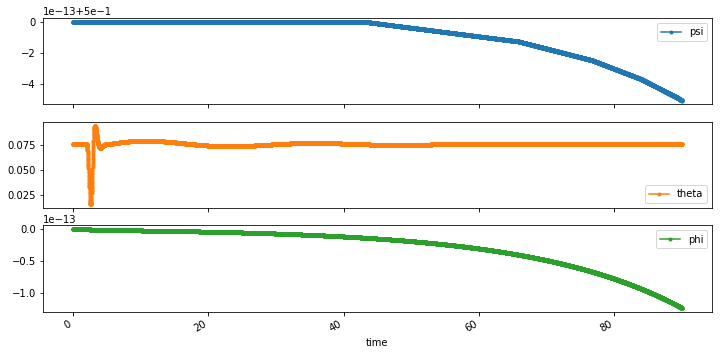

In [46]:
results.plot(y=['psi', 'theta', 'phi'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


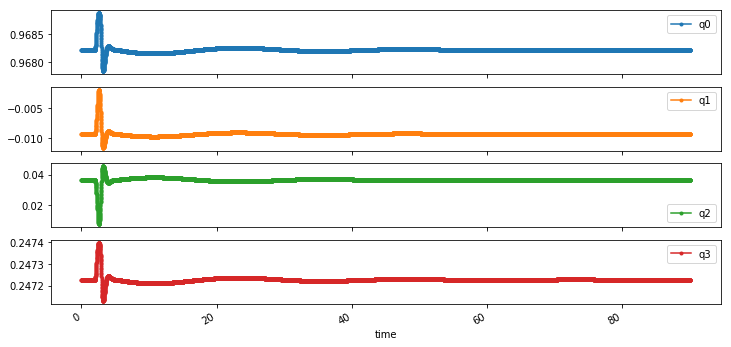

In [47]:
results.plot(y=['q0', 'q1', 'q2', 'q3'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


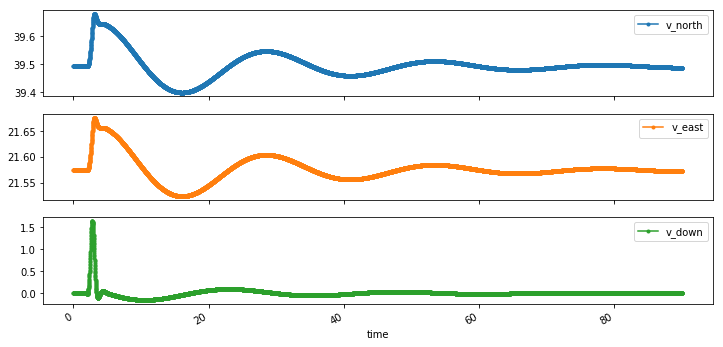

In [48]:
results.plot(y=['v_north', 'v_east', 'v_down'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


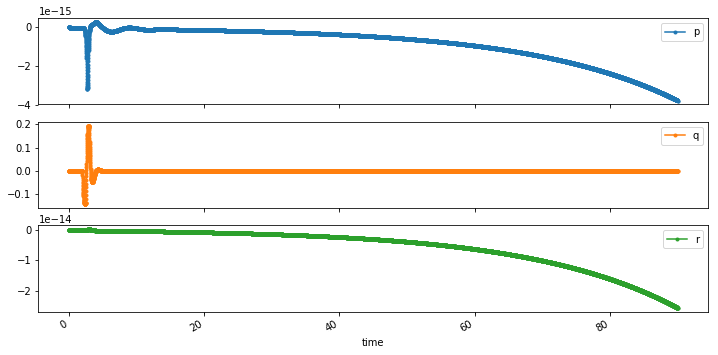

In [49]:
results.plot(y=['p', 'q', 'r'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


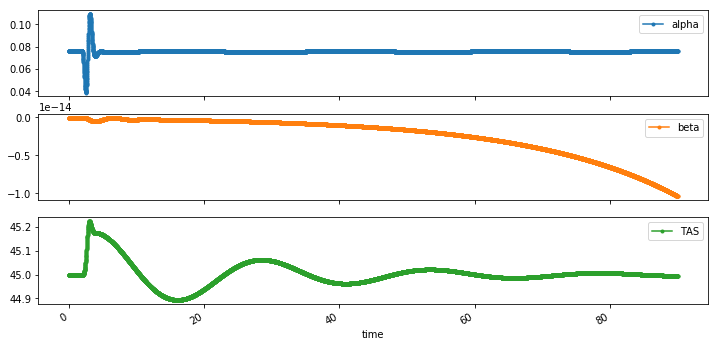

In [50]:
results.plot(y=['alpha', 'beta', 'TAS'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


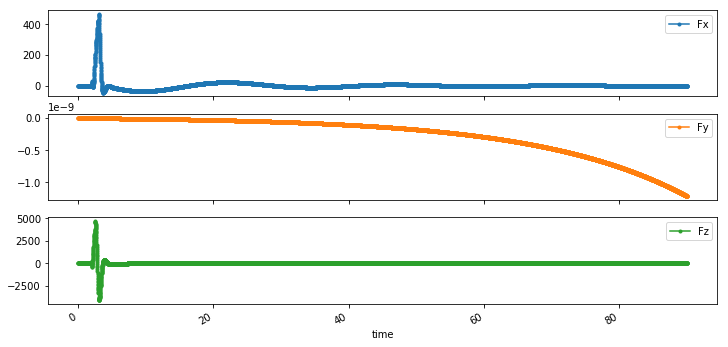

In [51]:
results.plot(y=['Fx', 'Fy', 'Fz'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


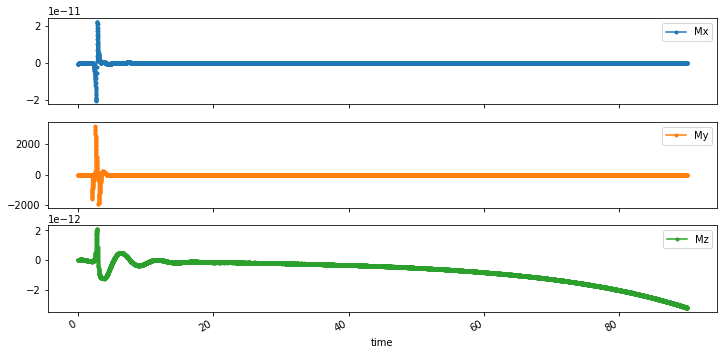

In [52]:
results.plot(y=['Mx', 'My', 'Mz'], **kwargs);

/home/asaez/miniconda3/envs/pyfme/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


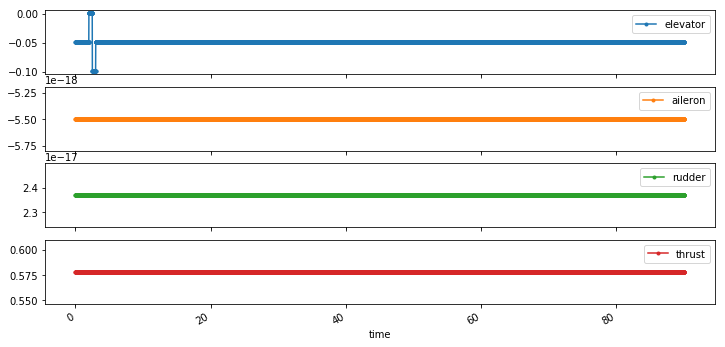

In [53]:
results.plot(y=['elevator', 'aileron', 'rudder', 'thrust'], **kwargs);

## Propagating only one time step

In [54]:
dt = 0.05  # seconds
sim = Simulation(aircraft, system, environment, controls, dt)

In [55]:
results = sim.propagate(0.5)
results

time: 100%|█████████▉| 0.49999999999999994/0.5 [00:00<00:00,  3.36it/s]


,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.05,1.466560e-11,-2.318226e-15,1.818989e-12,0.133756,-4.167205e-13,-1.211481e-11,1.444428e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.915157e-15,8.881784e-16,21.574149,39.491215,3.396464,1.974561,1.078707,-1000.0
0.10,1.546141e-11,-1.275346e-14,1.091394e-11,0.133756,-3.307165e-13,-9.664133e-12,1.748664e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.920609e-15,1.332268e-15,21.574149,39.491215,3.396464,3.949122,2.157415,-1000.0
0.15,1.546141e-11,-2.968746e-14,1.273293e-11,0.133756,-2.620941e-13,-7.189534e-12,3.035705e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.929976e-15,1.776357e-15,21.574149,39.491215,3.396464,5.923682,3.236122,-1000.0
0.20,1.546141e-11,-5.148946e-14,1.818989e-11,0.133756,-2.063307e-13,-5.817048e-12,4.177529e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.943139e-15,2.664535e-15,21.574149,39.491215,3.396464,7.898243,4.314830,-1000.0
0.25,1.557510e-11,-7.708650e-14,2.182787e-11,0.133756,-1.614866e-13,-3.934470e-12,4.019335e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.960394e-15,3.552714e-15,21.574149,39.491215,3.396464,9.872804,5.393537,-1000.0
0.30,1.568878e-11,-1.053956e-13,2.546585e-11,0.133756,-1.245945e-13,-2.279115e-12,4.693280e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.981719e-15,4.884981e-15,21.574149,39.491215,3.396464,11.847365,6.472245,-1000.0
0.35,1.602984e-11,-1.358224e-13,2.910383e-11,0.133756,-9.522920e-14,-1.249263e-12,4.100948e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.007532e-15,6.217249e-15,21.574149,39.491215,3.396464,13.821925,7.550952,-1000.0
0.40,1.602984e-11,-1.677902e-13,3.456080e-11,0.133756,-7.166550e-14,-1.472964e-14,3.845659e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.037226e-15,7.993606e-15,21.574149,39.491215,3.396464,15.796486,8.629660,-1000.0
0.45,1.659828e-11,-2.007405e-13,3.637979e-11,0.133756,-5.230678e-14,6.912957e-13,5.279284e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.070645e-15,9.769963e-15,21.574149,39.491215,3.396464,17.771047,9.708367,-1000.0


We can propagate for one time step even once the simulation has been propagated before:

In [56]:
results = sim.propagate(sim.time+dt)
results

time: 100%|██████████| 0.55/0.55 [00:00<00:00, 51.60it/s]


,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.05,1.466560e-11,-2.318226e-15,1.818989e-12,0.133756,-4.167205e-13,-1.211481e-11,1.444428e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.915157e-15,8.881784e-16,21.574149,39.491215,3.396464,1.974561,1.078707,-1000.0
0.10,1.546141e-11,-1.275346e-14,1.091394e-11,0.133756,-3.307165e-13,-9.664133e-12,1.748664e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.920609e-15,1.332268e-15,21.574149,39.491215,3.396464,3.949122,2.157415,-1000.0
0.15,1.546141e-11,-2.968746e-14,1.273293e-11,0.133756,-2.620941e-13,-7.189534e-12,3.035705e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.929976e-15,1.776357e-15,21.574149,39.491215,3.396464,5.923682,3.236122,-1000.0
0.20,1.546141e-11,-5.148946e-14,1.818989e-11,0.133756,-2.063307e-13,-5.817048e-12,4.177529e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.943139e-15,2.664535e-15,21.574149,39.491215,3.396464,7.898243,4.314830,-1000.0
0.25,1.557510e-11,-7.708650e-14,2.182787e-11,0.133756,-1.614866e-13,-3.934470e-12,4.019335e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.960394e-15,3.552714e-15,21.574149,39.491215,3.396464,9.872804,5.393537,-1000.0
0.30,1.568878e-11,-1.053956e-13,2.546585e-11,0.133756,-1.245945e-13,-2.279115e-12,4.693280e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-1.981719e-15,4.884981e-15,21.574149,39.491215,3.396464,11.847365,6.472245,-1000.0
0.35,1.602984e-11,-1.358224e-13,2.910383e-11,0.133756,-9.522920e-14,-1.249263e-12,4.100948e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.007532e-15,6.217249e-15,21.574149,39.491215,3.396464,13.821925,7.550952,-1000.0
0.40,1.602984e-11,-1.677902e-13,3.456080e-11,0.133756,-7.166550e-14,-1.472964e-14,3.845659e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.037226e-15,7.993606e-15,21.574149,39.491215,3.396464,15.796486,8.629660,-1000.0
0.45,1.659828e-11,-2.007405e-13,3.637979e-11,0.133756,-5.230678e-14,6.912957e-13,5.279284e-14,45.0,336.434581,-5.494432e-18,...,0.577997,44.87164,-2.070645e-15,9.769963e-15,21.574149,39.491215,3.396464,17.771047,9.708367,-1000.0


Notice that `results` will include the previous timesteps as well as the last one. To get just the last one one can use pandas `loc` or `iloc`:

In [57]:
results.iloc[-1]  # last time step

Fx             1.728040e-11
Fy            -2.680352e-13
Fz             4.183676e-11
Mach           1.337556e-01
Mx            -2.361979e-14
My             1.452475e-12
Mz             3.700375e-14
TAS            4.500000e+01
a              3.364346e+02
aileron       -5.494432e-18
alpha          7.554882e-02
beta          -4.776711e-17
elevator      -4.895112e-02
height         1.000000e+03
p             -7.865968e-17
phi           -3.048989e-17
pressure       8.987627e+04
psi            5.000000e-01
q             -1.297846e-15
q0             9.682212e-01
q1            -9.343316e-03
q2             3.659139e-02
q3             2.472275e-01
q_inf          1.125555e+03
r              7.502455e-18
rho            1.111660e+00
rudder         2.369098e-17
temperature    2.816510e+02
theta          7.554882e-02
thrust         5.779967e-01
u              4.487164e+01
v             -2.149520e-15
v_down         1.376677e-14
v_east         2.157415e+01
v_north        3.949122e+01
w              3.396

In [58]:
results.loc[sim.time]  # results for current simulation time

Fx             1.728040e-11
Fy            -2.680352e-13
Fz             4.183676e-11
Mach           1.337556e-01
Mx            -2.361979e-14
My             1.452475e-12
Mz             3.700375e-14
TAS            4.500000e+01
a              3.364346e+02
aileron       -5.494432e-18
alpha          7.554882e-02
beta          -4.776711e-17
elevator      -4.895112e-02
height         1.000000e+03
p             -7.865968e-17
phi           -3.048989e-17
pressure       8.987627e+04
psi            5.000000e-01
q             -1.297846e-15
q0             9.682212e-01
q1            -9.343316e-03
q2             3.659139e-02
q3             2.472275e-01
q_inf          1.125555e+03
r              7.502455e-18
rho            1.111660e+00
rudder         2.369098e-17
temperature    2.816510e+02
theta          7.554882e-02
thrust         5.779967e-01
u              4.487164e+01
v             -2.149520e-15
v_down         1.376677e-14
v_east         2.157415e+01
v_north        3.949122e+01
w              3.396